# SpectralFPM Simulation

Neerja Aggarwal

Oct 23rd, 2024

Simulate the measurement & attempt reconstruction for a spectral object. 


In [1]:
import fpm_helper as fpm
import matplotlib.pyplot as plt
import numpy as np
import torch
# plt.style.use('dark_background')

In [2]:
device = fpm.use_gpu(1)

cuda:1


# setup the fpm system

In [3]:
mag = 4 # 4x 
pix_size_camera = 4 #  micron"

wv_start = 400e-3 # micron
wv_end = 800e-3 # micron
wv_step = 100e-3 # micron
wv_range = np.arange(wv_start,wv_end, wv_step)
print(wv_range)

# wv = 500e-3 # micron
na_obj = 0.05 # low na objective 

fpm_setup = fpm.FPM_setup(mag = mag, pix_size_camera = pix_size_camera, wv = wv_range, na_obj = na_obj)
print(fpm_setup)

[0.4 0.5 0.6 0.7]
Using stock object data


/home/neerja/CODE/SpectralPtychographyProjectGitRepo/fpm_helper.py:145: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1729496767994/work/torch/csrc/utils/tensor_numpy.cpp:204.)
  im = torch.from_numpy(image.imread(path))[:, :, 0]  # Use first channel


FPM Setup Parameters:
--------------------
Camera pixel size: 4 microns
Magnification: 4x
Object pixel size: 1.000 microns
Numerical aperture: 0.05
Wavelength(s): [0.4 0.5 0.6 0.7] microns
Number of wavelengths: 4
Image dimensions: 1178 x 1178 pixels
LED Spacing: 5 mm
Distance: 75 mm
LED List: None
--------------------


# view the obj

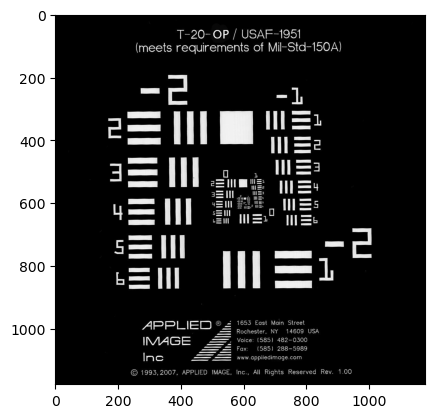

In [4]:
plt.imshow(torch.sum(fpm_setup.objstack, dim =0), cmap = 'gray')

# simulate some measurements

[((0.0, 0.0), (0, 1, 2, 3)), ((-0.017538068749853336, 0.02736674549466802), (0, 1, 2, 3)), ((0.0087391062189576, -0.03412197499050144), (0, 1, 2, 3)), ((0.02807133244175382, -0.0245544586214932), (0, 1, 2, 3)), ((0.01425215614679847, 0.035948497185189686), (0, 1, 2, 3)), ((0.04108222265466329, 0.017951344671923226), (0, 1, 2, 3)), ((0.027978661377197064, 0.03633310833730859), (0, 1, 2, 3)), ((0.03680015128940581, 0.028892719853420294), (0, 1, 2, 3)), ((-0.03044856730879639, 0.042531621380679396), (0, 1, 2, 3)), ((0.04717115330848985, -0.028484813074502558), (0, 1, 2, 3)), ((-0.056137793485574704, -0.025181894283366115), (0, 1, 2, 3)), ((0.04480827657349049, 0.046739533503339446), (0, 1, 2, 3)), ((-0.030528592562585683, 0.058291532381192175), (0, 1, 2, 3)), ((0.060766402919284625, -0.027425747467248515), (0, 1, 2, 3)), ((0.02972134491376003, 0.0612037920825107), (0, 1, 2, 3)), ((-0.07267849074174247, -0.03428136658600597), (0, 1, 2, 3)), ((0.07880795225016785, -0.018580788321043696), (0

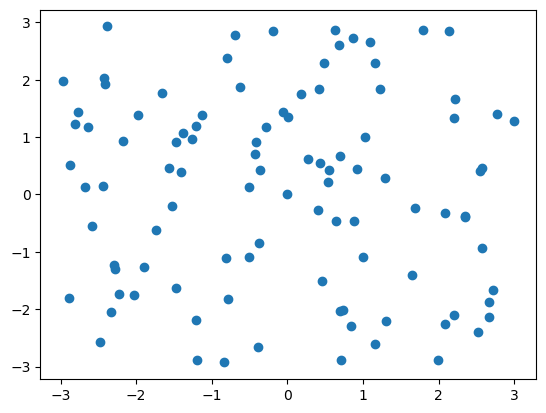

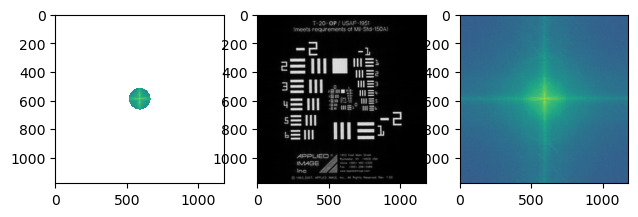

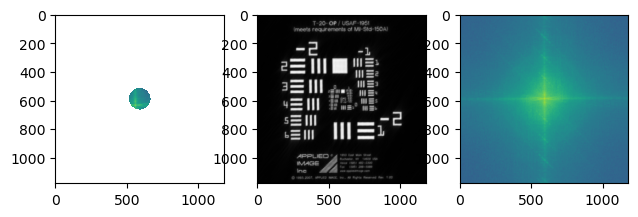

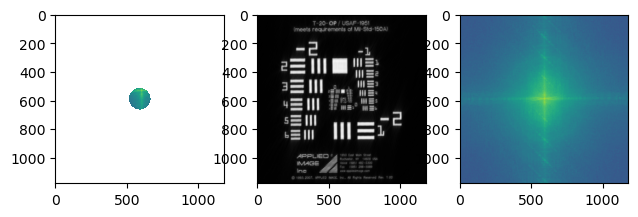

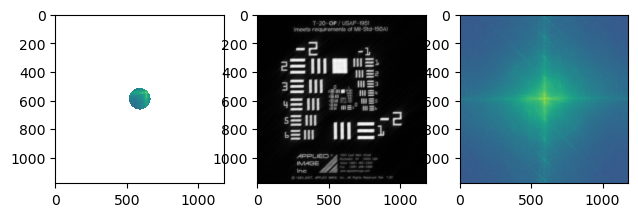

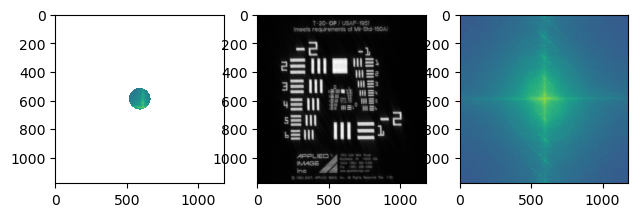

In [5]:
d = 75
led_spacing = 5
num_leds = 100
list_leds = fpm.createlist_led(num_leds,-3,3) 
# print(list_leds)
plt.scatter(list_leds[:,1],list_leds[:,0])
list_illums = fpm_setup.createUniformWavelengthPerAngleIllumList(list_leds)
print(list_illums)
measstack = fpm_setup.createMeasStackFromListIllums()

# Recon

In [6]:
recon = fpm.Reconstruction(fpm_setup, measstack, device = 2)
recon.initRecon()
recon.parameters(step_size=1e-3, num_iters=100)
print(recon)

cuda:2
Reconstruction Parameters:
--------------------
Number of measurements: 101
Device: cuda:2
--------------------
FPM Setup Parameters:
--------------------
Camera pixel size: 4 microns
Magnification: 4x
Object pixel size: 1.000 microns
Numerical aperture: 0.05
Wavelength(s): [0.4 0.5 0.6 0.7] microns
Number of wavelengths: 4
Image dimensions: 1178 x 1178 pixels
LED Spacing: 5 mm
Distance: 75 mm
LED List: [[ 0.          0.        ]
 [-0.26309801  0.41060369]
 [ 0.13108993 -0.51202836]
 [ 0.42118062 -0.36839092]
 [ 0.21379682  0.53945986]
 [ 0.61658026  0.2692991 ]
 [ 0.41978946  0.54523657]
 [ 0.55225159  0.43351143]
 [-0.45686971  0.63835928]
 [ 0.70809257 -0.42738779]
 [-0.8429526  -0.37780828]
 [ 0.67257434  0.70160398]
 [-0.4580712   0.87536468]
 [ 0.91261962 -0.41148939]
 [ 0.44595149  0.91920492]
 [-1.09210092 -0.51442203]
 [ 1.18457264 -0.2787439 ]
 [ 0.29288102  1.2911362 ]
 [ 1.35152568  0.00794629]
 [-1.10742989 -0.81773537]
 [ 1.00060029  1.02382722]
 [ 1.43730477 -0.05

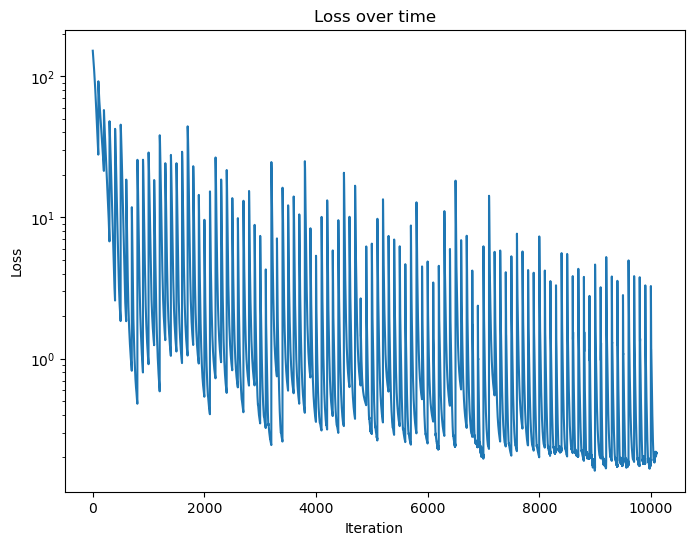

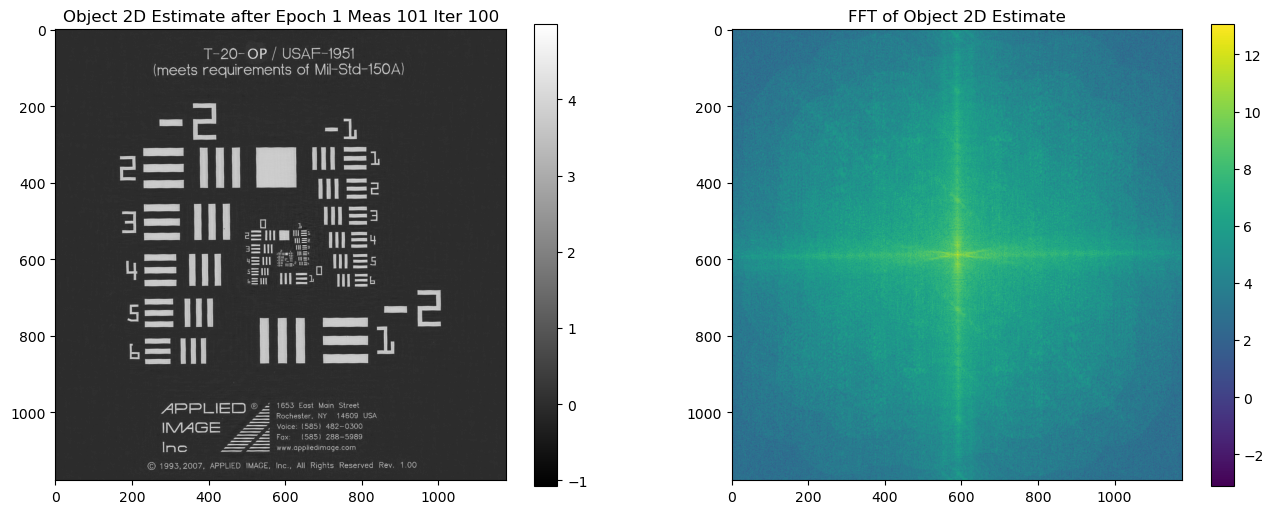

In [7]:
recon.train()

In [8]:
objest = recon.objest.detach().cpu().numpy()

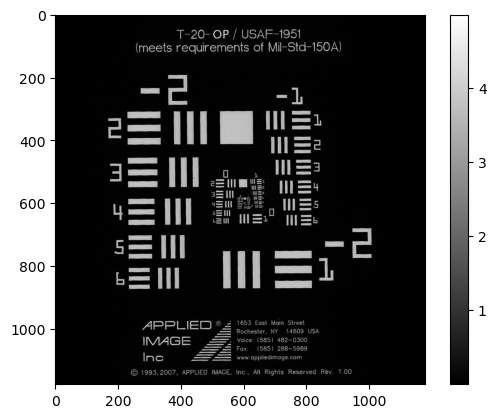

In [9]:
plt.imshow(np.abs(np.sum(objest, axis = 0)), cmap = 'gray')
plt.colorbar()

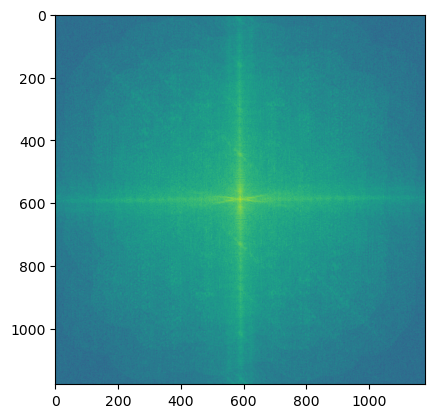

In [10]:
plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(np.squeeze(np.sum(objest, axis = 0)))))))

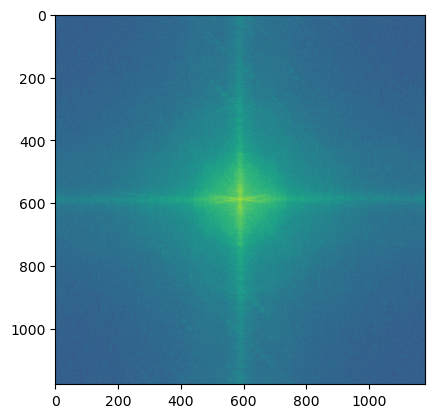

In [11]:
plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(np.squeeze(recon.fpm_setup.measstack[0].cpu().numpy()))))))

## compare wavelength channels

Text(0.5, 1.0, '800 nm')

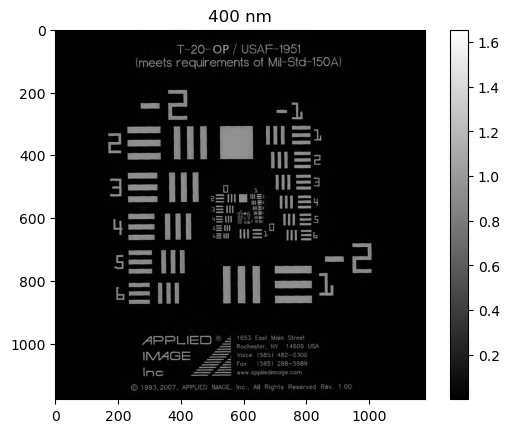

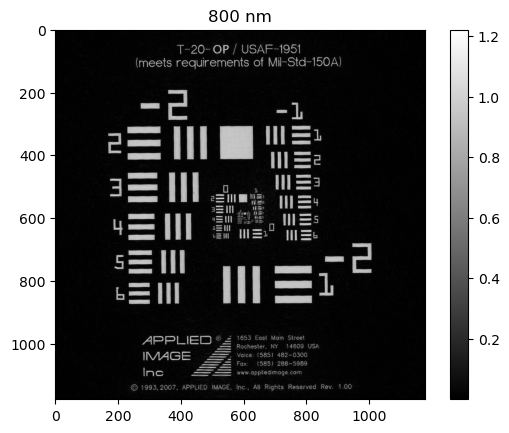

In [12]:
plt.imshow(np.abs(objest[0,:,:]), cmap = 'gray')
plt.colorbar()
plt.title('400 nm')
plt.figure()
plt.imshow(np.abs(objest[-1,:,:]), cmap = 'gray')
plt.colorbar()
plt.title('800 nm')
